#### Step 2  <br>
Prepare various files for doing preprocessing:
1. Fieldmaps from blip up/down procedure (topup)
2. Brain extraction
3. FSF files for each run

In [71]:
# python imports
from os import listdir, makedirs, walk, remove, getlogin
from os.path import isfile, join, exists
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import shutil
import pandas as pd
import socket
from nilearn import image, plotting


In [ ]:
# set subject specific info
subjects = 'impr_g1_s2_020118'


In [2]:
# set various paths

# Set projdirs dir
projdir = '/mnt/bucket/labs/hasson/mai/projects/impressions'
datadir = join(projdir, 'data')
acqdir = join(projdir, 'acq_params')

# Set code dir
codedir = '/mnt/bucket/labs/hasson/mai/code/preproc/bash'

# Rawdir
rawdir = join('raw', 'niftis_good')

# Set acqparams file
acqparams_file = join(acqdir, 'acqparams.txt')

# Set config file
config_file = join(acqdir, 'b02b0.cnf')

# Set fieldmap filesnames
fieldmap_ap_name = 'se_fieldmap_ap.nii.gz'
fieldmap_pa_name = 'se_fieldmap_pa.nii.gz'
last_epi = 'epi_pieman.nii.gz'

In [7]:
# Create fieldmap files using fsl's topup command. More details below, but in brief:
# 1. Merges SE fieldmaps into single file
# 2. Run's FSL topup fx to correct the fieldmaps
# 3. Convert corrected fieldmaps to magnitude map by taking average
# 4. Convert corrected phase map in Hz to phase map in rads    

# create output dir
outdir = join(datadir, this_sub, 'preproc', 'unwarp_out', 'unwarp_files')
if not exists(outdir):
    print(outdir + ' does not exist, creating')
    makedirs(outdir)

# set fieldmap dir and files
raw_nifti_dir = join(datadir, this_sub, 'raw', 'niftis_good')
fieldmap_ap = join(fieldmap_dir, this_sub + '_' + fieldmap_ap_name)
fieldmap_pa = join(fieldmap_dir, this_sub + '_' + fieldmap_pa_name)
ref_epi = join(raw_nifti_dir, this_sub + '_' + last_epi)

# run topup
!{join(codedir, 'prep_unwarpFiles.sh')} {outdir} {fieldmap_ap} {fieldmap_pa} {acqparams_file} {config_file} {ref_epi}


output path for files: /mnt/bucket/labs/hasson/mai/projects/impressions/data/impr_g1_s2_020118/preproc/unwarp_out/unwarp_files
input_AP: /mnt/bucket/labs/hasson/mai/projects/impressions/data/impr_g1_s2_020118/raw/niftis_good/impr_g1_s2_020118_se_fieldmap_ap.nii.gz
input_PA: /mnt/bucket/labs/hasson/mai/projects/impressions/data/impr_g1_s2_020118/raw/niftis_good/impr_g1_s2_020118_se_fieldmap_pa.nii.gz
input acq file: /mnt/bucket/labs/hasson/mai/projects/impressions/acq_params/acqparams.txt
input cnf file: /mnt/bucket/labs/hasson/mai/projects/impressions/acq_params/b02b0.cnf
input ref epi: /mnt/bucket/labs/hasson/mai/projects/impressions/data/impr_g1_s2_020118/raw/niftis_good/impr_g1_s2_020118_epi_pieman.nii.gz


concatenating se fielmdaps ...
concat_fieldmaps exists, skipping step
done!

running topup to create fieldmap files ...
done!

calc mean map...
done!

extracting brain from mean mag map using Bet
done!

converting phase map to pixel shift map...
done

converting pixel-shift map i

In [ ]:
# Look at original spin echo maps in the concat file

for this_sub in subjects:
    
    # create output dir
    outdir = join(datadir, this_sub, 'preproc', 'B0')

    # look at topup outputs: fsl merge
    fieldmap = join(outdir, 'concat_fieldmaps.nii.gz')

    # first SE in AP direction image
    plotting.plot_anat(image.index_img(fieldmap,0), cut_coords=[3,-1,10], dim=-1, title='orig_se_ap')
    plt.show()

    # first SE in PA direction image
    plotting.plot_anat(image.index_img(fieldmap,3), cut_coords=[3,-1,10], dim=-1, title='orig_se_pa')
    plt.show()


In [ ]:
# look at the corrected SE maps

for this_sub in subjects:
    
    # create output dir
    outdir = join(datadir, this_sub, 'preproc', 'B0')

    # look at topup outputs: fsl merge
    fieldmap = join(outdir, 'topup_iout.nii.gz')

    # first SE in AP direction image
    plotting.plot_anat(image.index_img(fieldmap,0), cut_coords=[3,-1,10], dim=-1, title='corr_se_ap')
    plt.show()

    # first SE in PA direction image
    plotting.plot_anat(image.index_img(fieldmap,3), cut_coords=[3,-1,10], dim=-1, title='corr_se_pa')
    plt.show()


In [ ]:
# Check magnitude map from averaging the corrected spin echo maps
for this_sub in subjects:
    
    # set output dir
    outdir = join(datadir, this_sub, 'preproc', 'B0')

    # first SE in AP direction image
    plotting.plot_anat(join(outdir, 'magnitude.nii.gz'), cut_coords=[3,-1,10], dim=-1, title='mag map')
    plt.show()

    # first SE in PA direction image
    plotting.plot_anat(join(outdir, 'magnitude_brain.nii.gz'), cut_coords=[3,-1,10], dim=-1, title='mag map brain')
    plt.show()

In [ ]:
# Check phase map
for this_sub in subjects:
    
    # set output dir
    outdir = join(datadir, this_sub, 'preproc', 'B0')

    # first SE in AP direction image
    plotting.plot_anat(join(outdir, 'topup_fout_rads.nii.gz'), cut_coords=[3,-1,10], dim=0, title='phase map')
    plt.show()


In [3]:
# If all of the above look okay, move on to applywarp to correct for motion and B0 distortions

# load subject data
this_sub = 'impr_g1_s2_020118'
subInfo = pd.read_csv(join(datadir, this_sub, 'scanInfo.csv'))
scanN = 3

# Set subject's dir
subdir = join(datadir, this_sub, 'preproc', 'unwarp_out')

# Set up directories
outdir = join(subdir, 'run' + str(scanN))
if not exists(outdir):
    print(outdir + ' does not exist, creating')
    makedirs(outdir)
mcdir = join(outdir, 'mc')
if not exists(mcdir):
    print(mcdir + ' does not exist, creating')
    makedirs(mcdir)
    
# epi to process
epi_in = join(datadir, this_sub, 'raw', 'niftis_good', subInfo.loc[3]['scanName'])

# epi savename
epi_out = join(outdir, 'run' + str(scanN) + '_unwarped.nii.gz')

!{join(codedir, 'apply_unwarp.sh')} {str(scanN)} {subdir} {epi_in} {epi_out}

calc motion correction xform mats for run 3 with mcflirt...
done!

concat motion correction xform mats...
done!

applying motion correction and B0 correction ...
done!



/jukebox/pkgs/ANACONDAPY/ni/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


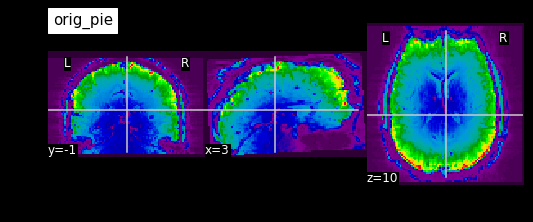

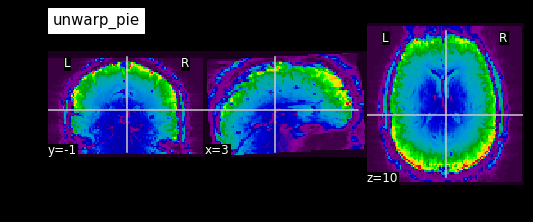

In [11]:
# check files
plotting.plot_epi(image.mean_img(epi_in), cut_coords=[3,-1,10], title='orig_pie')
plt.show()

plotting.plot_epi(image.mean_img(epi_out), cut_coords=[3,-1,10], title='unwarp_pie')
plt.show()



In [50]:
# check motion over time
mc_file = open(join(subdir, 'run3', 'mc', 'EPI_mcf.par'), 'r')
count = len(mc_file.readlines())
mc_file.close()

# initialize motion params mat
mc_params = np.full([count,6], np.nan)

# read in lines
mc_file = open(join(subdir, 'run3', 'mc', 'EPI_mcf.par'), 'r')
for i,line in enumerate(mc_file):
    this_line = line.strip()
    vals = [float(i) for i in line.split()]
    mc_params[i:] = vals

mc_file.close()


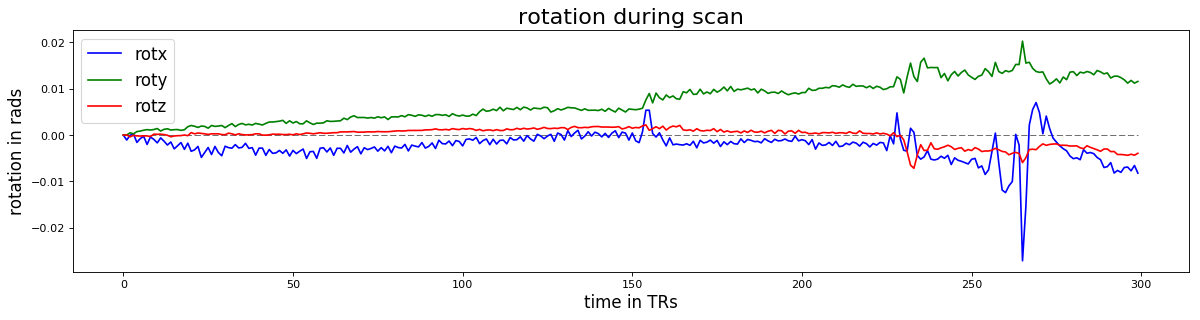

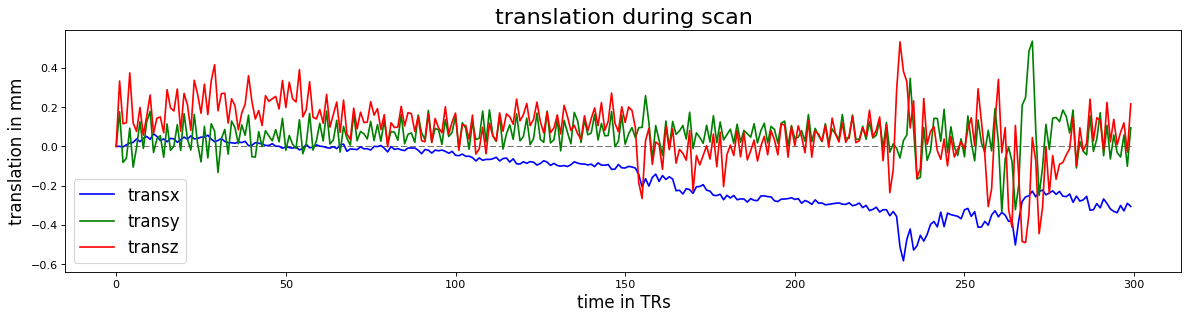

In [91]:
# plot motion
rotx = mc_params[:,0]
roty = mc_params[:,1]
rotz = mc_params[:,2]
transx = mc_params[:,3]
transy = mc_params[:,4]
transz = mc_params[:,5]

fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
_ = plt.plot(np.full([count,1],0), 'k--', linewidth=.5)
_ = plt.plot(rotx, 'b', label='rotx')
_ = plt.plot(roty, 'g', label='roty')
_ = plt.plot(rotz, 'r', label='rotz')
_ = plt.legend(fontsize=15)
_ = plt.ylabel('rotation in rads', fontsize=15)
_ = plt.xlabel('time in TRs', fontsize=15)
_ = plt.title('rotation during scan', fontsize=20)
_ = plt.show()

fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
_ = plt.plot(np.full([count,1],0), 'k--', linewidth=.5)
_ = plt.plot(transx, 'b', label='transx')
_ = plt.plot(transy, 'g', label='transy')
_ = plt.plot(transz, 'r', label='transz')
_ = plt.legend(fontsize=15)
_ = plt.ylabel('translation in mm', fontsize=15)
_ = plt.xlabel('time in TRs', fontsize=15)
_ = plt.title('translation during scan', fontsize=20)
_ = plt.show()

In [43]:
mc_file.close()

### Make files for doing fieldmap correction using topup

Meir's function for doing this is: slurm_fslblip.sh. It takes five arguments:
1. Path to fieldmaps
2. Name of AP fieldmap
3. Name of PA fieldmap
4. FSL topup aquisition params filename (not sure what this is yet, const_fsltopup_acqparams_file_name)
5. FSL topup CNF filename (also not sure what this is, const_fsltopup_cnf_file_name)

** Here is the procedure for creating these the topup files for b0 correction **
1. Use FSLmerge to merge the two SE fieldmaps into one file (all_SE)
2. The aqusition params file (4 above) you have to create manually. This file has a line for each of the 6 fieldmaps and specifies direction of encoding and total readout in seconds. AP = 1, and PA = -1, so if you have AP, AP, AP, PA, PA,PA, the first three columsn should be: [0 1 0] for AP, and [0 -1 0] for PA. The total readout is calculated seperately, following instructions here: https://pni-facilities.princeton.edu/index.php/Method_2:_Blip-up_blip-down_field_map_correctio
3. The CNF configuration file (5 above) is provided by fsl and should work without any modifications. On spock it is located at  /jukebox/pkgs/FSL/5.0.9/etc/flirtsch/
4. Check SE files to make sure they look okay!!
5. Run topup. Check files
6. Need a magnitude map to do correction. Use fslmaths to do get average of the 6 images
7. Need a phase map to o correction. Use fslmaths to get phase map in radians from fsl_topup_fout

**Calculating the aquisition time for file 4**

**Method 1:** Use this formula based on scan parameters of your BOLD EPI protocol:
* Formula: ((Matrix size / IPAT_factor) -1 ) * echo spacing in seconds = Readout time in seconds
* Example: ((104/2)-1)*0.00056 = 0.02856 sec
* For my scan
  * Matrix size: base res = 96. 
      * In dicom file, you can find this as Private_0051_100b, which is size of the image in the phase encoding direction
  * IPAT factor = 1 (no ipat)
  * Echo spacing in seconds: 
      * echo spacing needs to be divided by ipat factor
      * can ignore partial fourier and multiband sms
      * echo spacing = 0.7 ms -> 0.0007
  * ((96 / 1) - 1) * .0007 = __0.0665__
 
Or use this formula (again, based off your BOLD EPI protocol):
 Formula: (number of phase encoding steps - 1) * effective echo spacing in sec = Total readout time in sec
 Example: (103-1)*0.00027999 = 0.02855898 sec
 
**Method2:** Use this formula based on scan parameters of your BOLD EPI protocol:
* Formula: (number of phase encoding steps - 1) * effective echo spacing in sec = Total readout time in sec
   * Also note that "number of phase encoding steps" should be had you had to collect all k-space lines (i.e, all phase-encoding steps). So if your EPI protocol uses phase partial fourier (often, 7/8 or 6/8) you cannot use the value in the dicom header and instead you should provide the total number of phase encoding steps had you turned off partial k-space sampling.
* Example: (103-1)*0.00027999 = 0.02855898 sec
* For my scan:
   * Number of phase encoding steps = 84 (from dicom header, NumberOfPhaseEncodingSteps)
       * Phase partial fourier: 7/8
       * Actual Number of Steps = 84 * 8/7 = 96
   * Effective echo spacing = echo spacing / ipat factor
       * echo spacing in sec = .0007
       * ipat = 1
       * effective echo spacing = .0007
   * (96 - 1) * .0007 = __0.0665__


## Motion correction and fieldmap correction steps

1. Convert phase map from topup (topup_fout.nii.gz) to a pixel-shift map
    * fslmaths <topup_fout> -mul <readouttimeinsec> <output>
        * readoutimeinsec is from above: 0.0665
        * this is the original topup_fout file in Hz, not the converted one in radians!!
2. Convert to deformation (warp) map
    * convertwarp -r <magnitude> -s <shiftmap> -o <output> -d <unwarpdirection> y
    * checked both unwarp dirs, y and y-. y is the correct one
    
    